
## Quality Control and pre-processing

In [1]:
import os
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import hdf5plugin
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb
import path_config

import warnings
warnings.filterwarnings("ignore")
sb.set_context(context='poster')

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

scanpy==1.9.8 anndata==0.9.2 umap==0.5.5 numpy==1.24.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.1.3 statsmodels==0.14.1 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


In [2]:
# Filtering parameters

HOW_MANY_HIGHLY_VARIABLE_GENES = 10000 
MIN_CELL_COUNTS = 10000
MIN_GENES = 3000
MIN_CELLS_WITH_GENE = 5
MITOCHONDRIAL_THRESHOLD_PCT = 5

Get path to merged adata object that contains all sample data

In [3]:
merged_adata_file_name = "all_merged.h5ad"
adata_path = os.path.join(path_config.output_path,merged_adata_file_name)

Read adata

In [4]:
adata = ad.read_h5ad(adata_path)
adata

AnnData object with n_obs × n_vars = 4224 × 35546
    obs: 'barcode', 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'area', 'cell_id', 'batch'
    var: 'gene_id', 'gene_name'

In [5]:
# define all paths for storing data
campari_file = 'campari_scs_' + str(HOW_MANY_HIGHLY_VARIABLE_GENES) + '_from_R.h5ad'
campari_file_all_genes = 'campari_scs_all_genes_' + str(HOW_MANY_HIGHLY_VARIABLE_GENES) + '_from_R.h5ad'
campari_file_all_genes_normed = 'campari_scs_all_genes_norm_' + str(HOW_MANY_HIGHLY_VARIABLE_GENES) + '_from_R.h5ad'

# QC

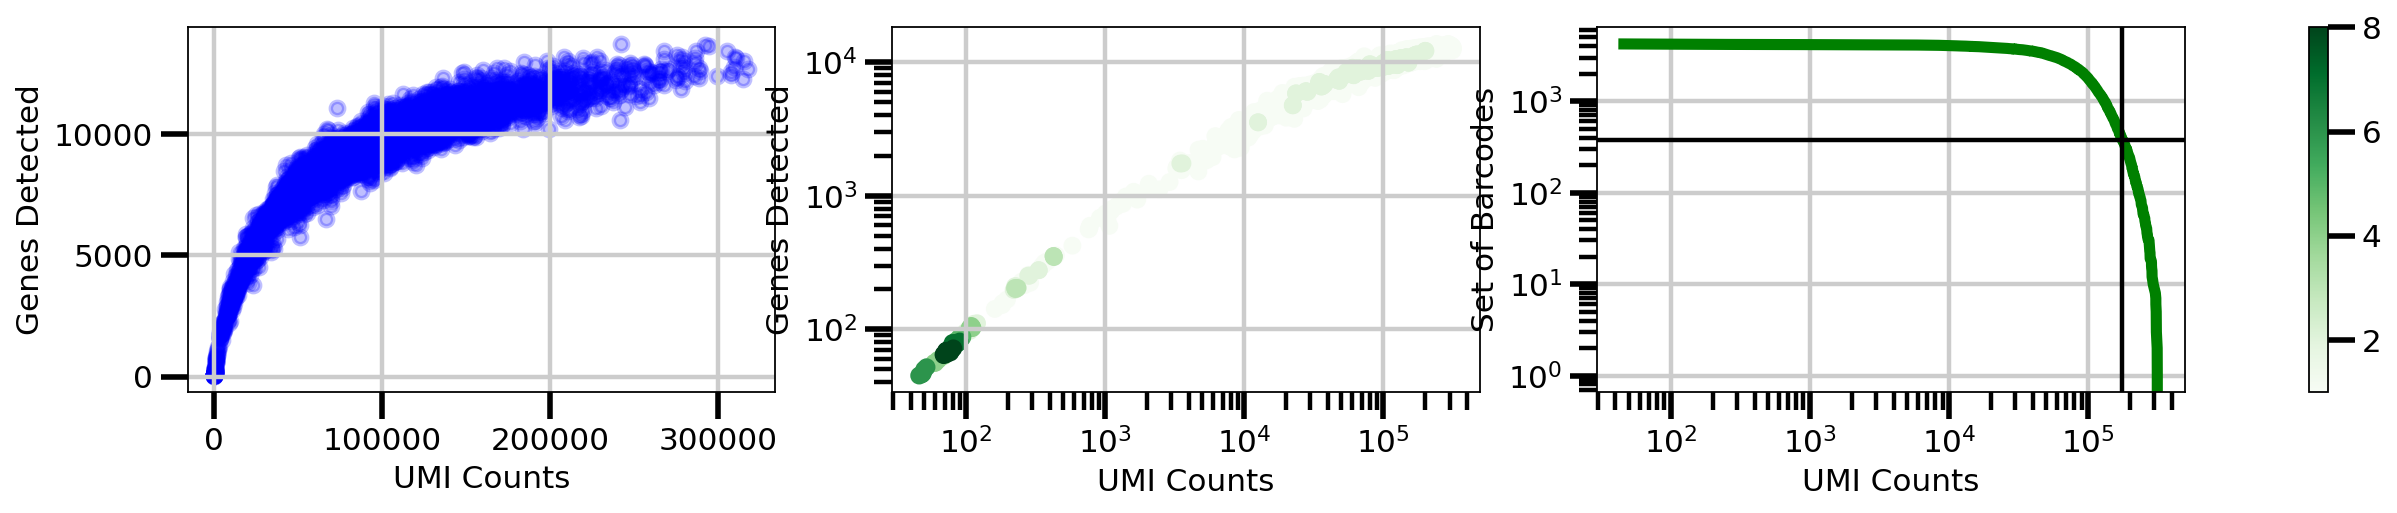

In [6]:
#### RECREATE PLOTS THAT ARE GIVEN IN THE REPORT 

#Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(1,3)
x = np.asarray(adata.X.sum(axis=1))
y = np.asarray(np.sum(adata.X>0, axis=1))
ax[0].scatter(x, y, color="b", alpha=0.25)
ax[0].set_ylabel("Genes Detected")
ax[0].set_xlabel("UMI Counts")


#histogram definition
bins = [1500, 1500] # number of bins
# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)
# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

s = ax[1].scatter(x2, y2, c=z2, cmap='Greens')  
fig.colorbar(s, ax=ax)

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel("UMI Counts")
ax[1].set_ylabel("Genes Detected")


expected_num_cells =  380#@param {type:"integer"}
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

ax[2].loglog(knee, range(len(knee)), linewidth=5, color="g")
ax[2].axvline(x=knee[expected_num_cells], linewidth=2, color="k")
ax[2].axhline(y=expected_num_cells, linewidth=2, color="k")

ax[2].set_xlabel("UMI Counts")
ax[2].set_ylabel("Set of Barcodes")


fig.set_size_inches([20,3])
plt.show()

## Filter by MIN_CELL_COUNTS

In [7]:
# Filter cells according to identified QC thresholds:
print('Total number of cells before: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, min_counts = MIN_CELL_COUNTS)
print('Total number of cells after: {:d}'.format(adata.n_obs))

Total number of cells before: 4224
filtered out 174 cells that have less than 10000 counts
Total number of cells after: 4050


## Filter by MIN_GENES

In [8]:
print('Number of cells before: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, min_genes = MIN_GENES)
print('Total number of cells after: {:d}'.format(adata.n_obs))

Number of cells before: 4050
filtered out 4 cells that have less than 3000 genes expressed
Total number of cells after: 4046


## Filter by MIN_CELLS_WITH_GENE

In [9]:
print('Number of genes before: {:d}'.format(adata.n_vars))
sc.pp.filter_genes(adata, min_cells=MIN_CELLS_WITH_GENE)
print('Number of genes after: {:d}'.format(adata.n_vars))

Number of genes before: 35546
filtered out 6500 genes that are detected in less than 5 cells
Number of genes after: 29046


## Handle mitochondrial genes

In [10]:
# annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('mt-')  
adata.var[adata.var['mt']]


,gene_id,gene_name,n_cells,mt
gene_name,,,,
mt-Rnr1,mt-Rnr1,mt-Rnr1,4042,True
mt-Rnr2,mt-Rnr2,mt-Rnr2,4046,True


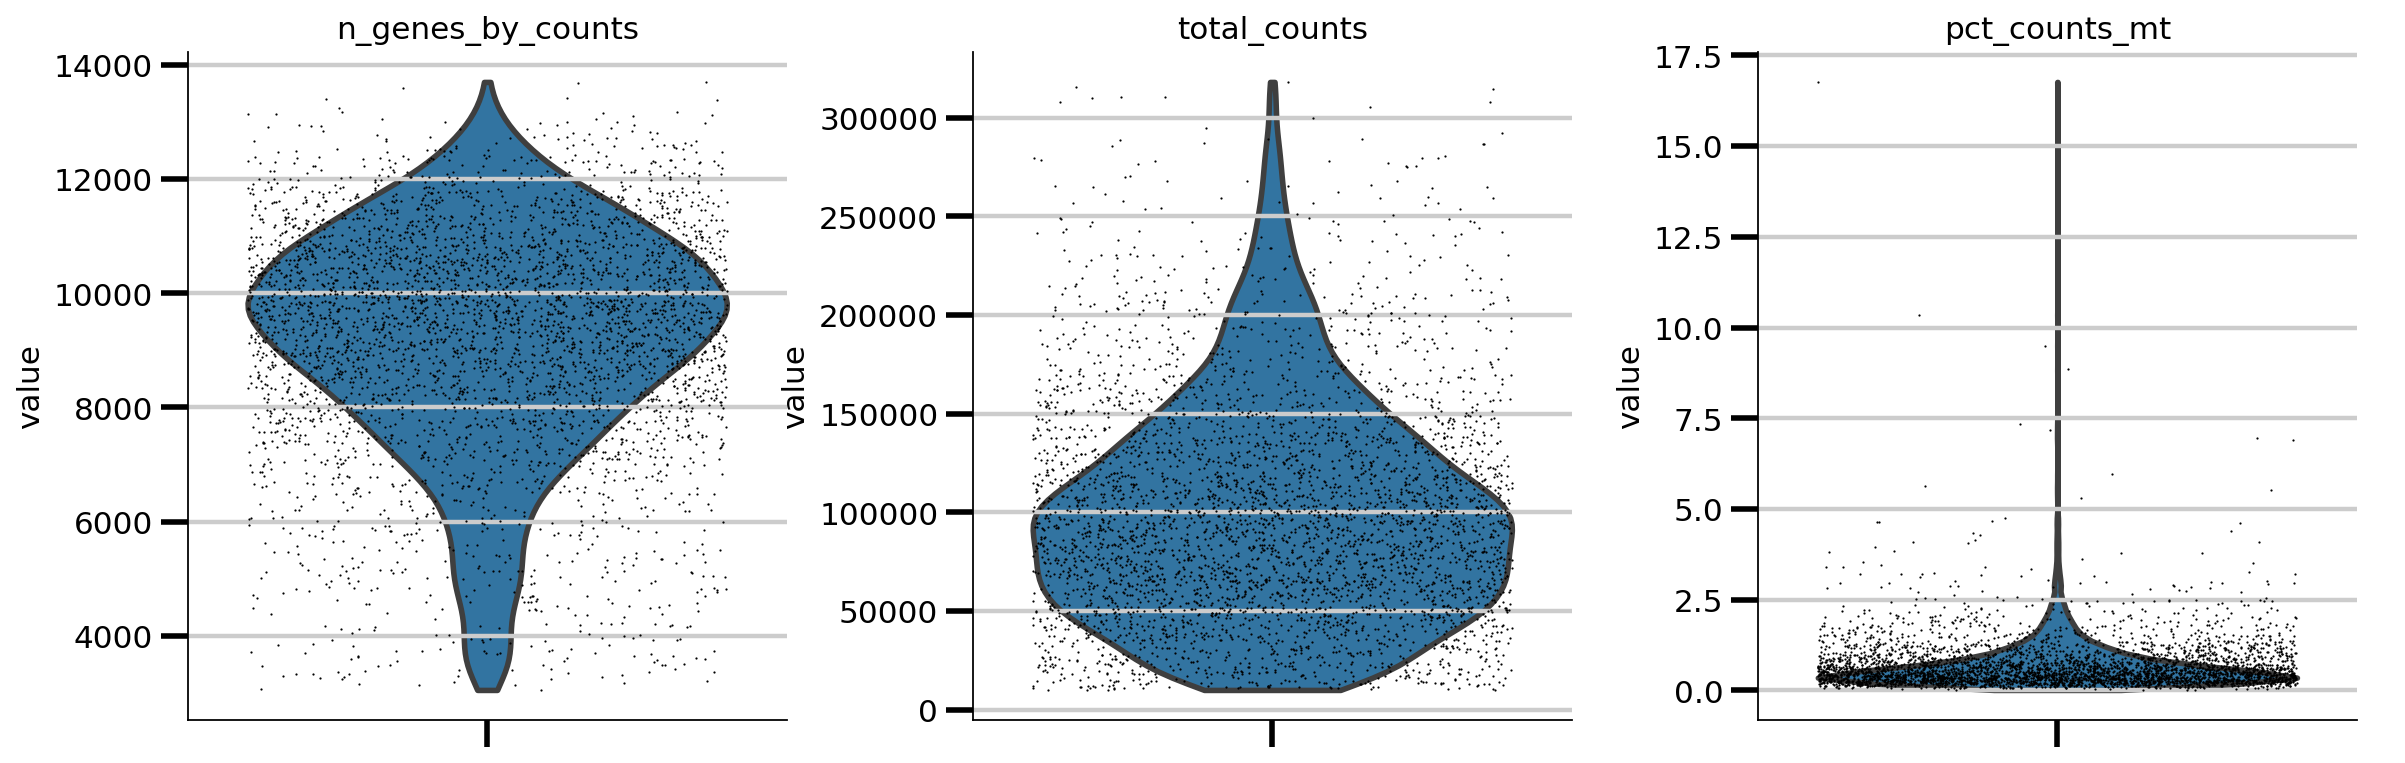

In [11]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

By plate

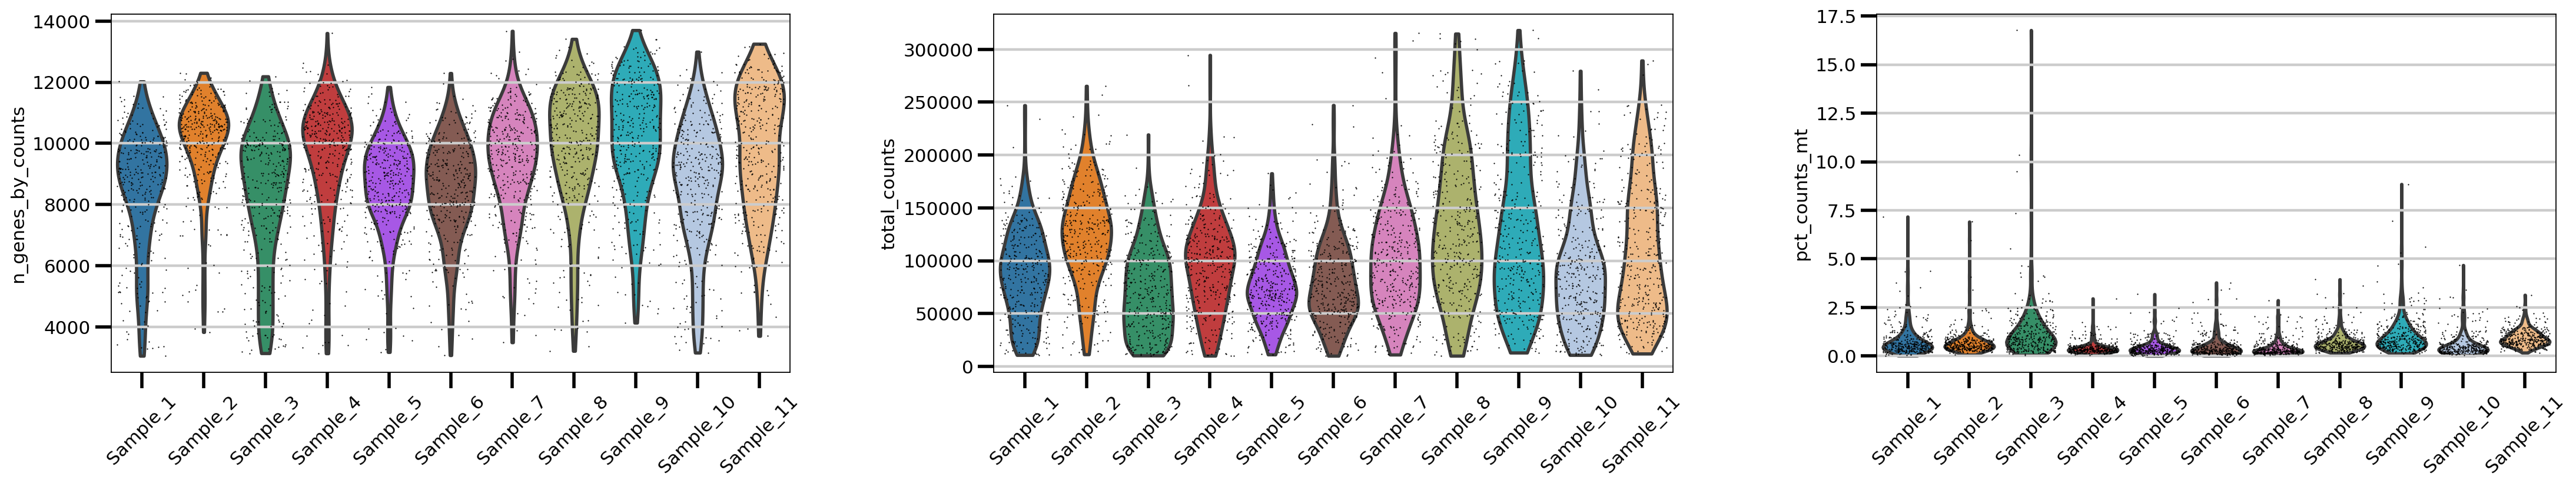

In [12]:
rcParams['figure.figsize']=(8,5)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, groupby = 'sample', rotation=45)

## Filter by MITOCHONDRIAL_THRESHOLD_PCT

Number of cells before: 4046
Number of cells after: 4034


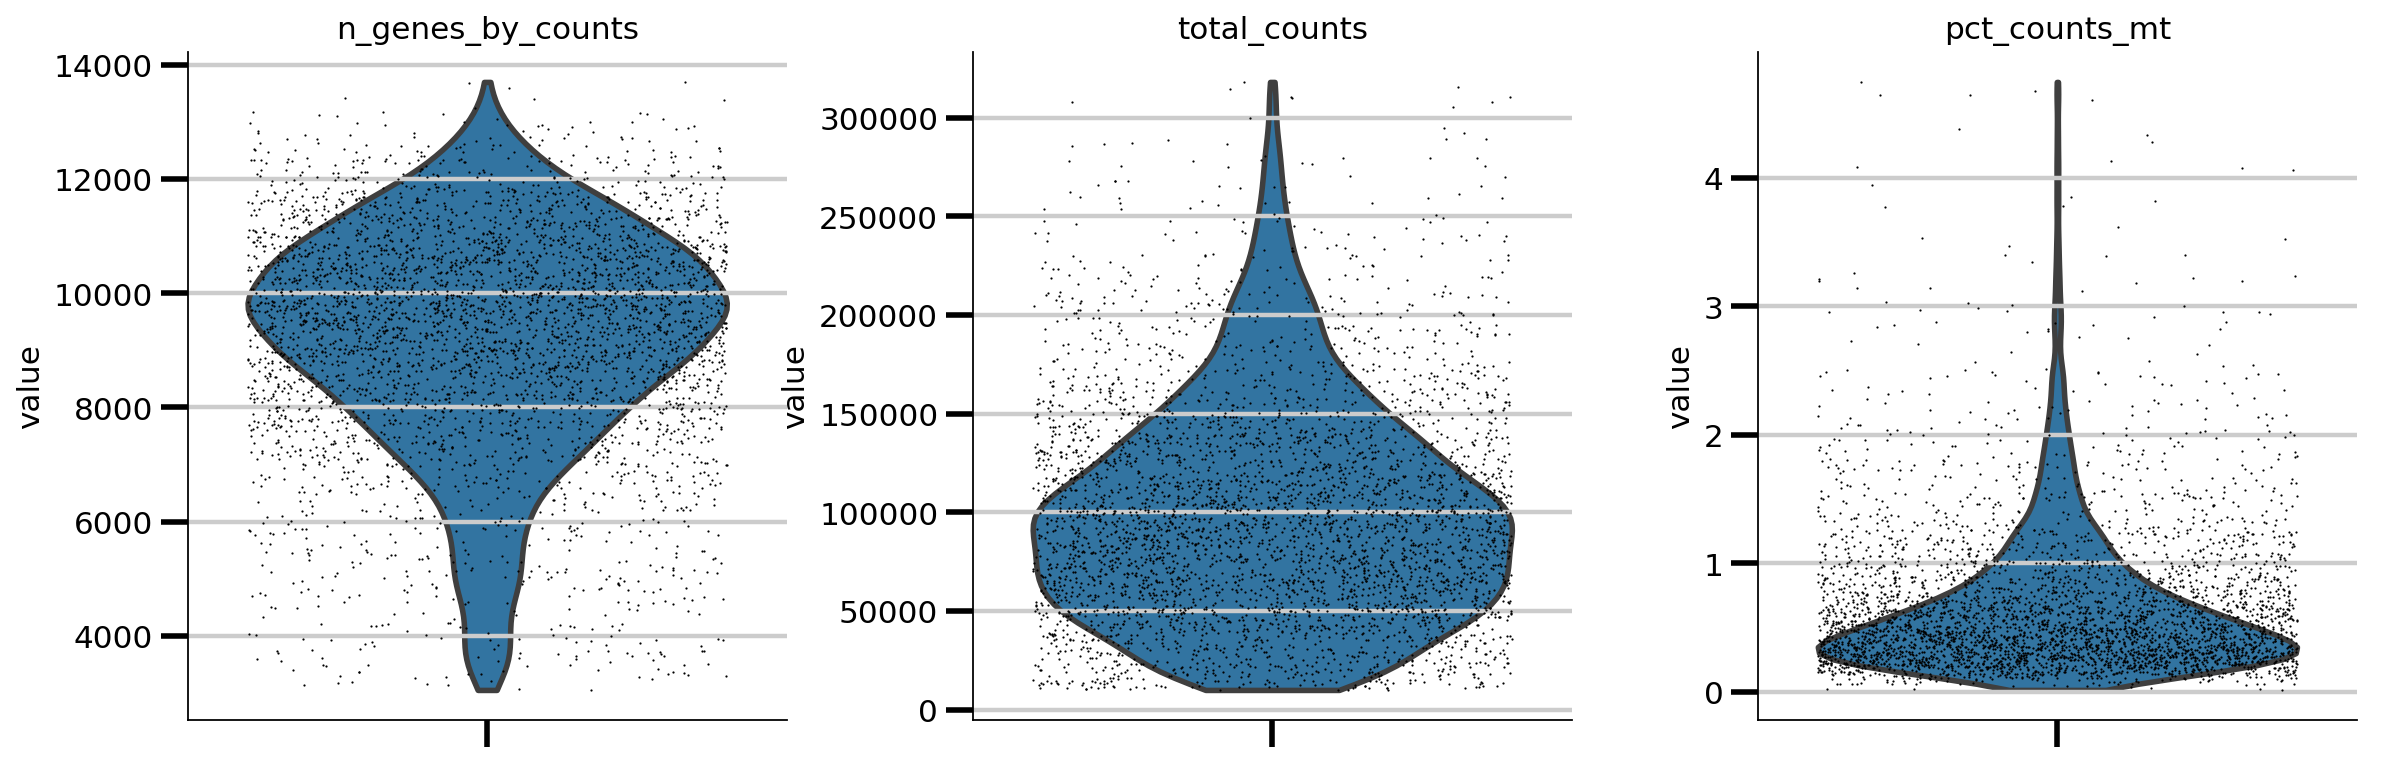

In [13]:
# Do the filtering by slicing the AnnData object
print('Number of cells before: {:d}'.format(adata.n_obs))
# keep only below 5% mitochondrial
adata = adata[adata.obs.pct_counts_mt < MITOCHONDRIAL_THRESHOLD_PCT, :]
print('Number of cells after: {:d}'.format(adata.n_obs))
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

## Export filtered, not normalized data

In [14]:
# save all genes before filtering highly variable
adata.write_h5ad(
    os.path.join(path_config.output_path, campari_file_all_genes)
) 

## LogNormalize

In [15]:
# Normalize 
# Seurat tutorial uses: LogNormalize: 
sc.pp.normalize_total(adata, target_sum=1e4) 
# Logarithmize the data
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


## Export Filtered and Normalized data

In [16]:
# save all genes before filtering highly variable but normed
adata.write_h5ad(
    os.path.join(path_config.output_path, campari_file_all_genes_normed)
) 

In [ ]:
# You can get back an AnnData of the object in .raw by calling .raw.to_adata()
adata.raw = adata # this will keep log normalized data in our data object

## Highly Variable Genes

In [18]:
# select only highly variable genes
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=HOW_MANY_HIGHLY_VARIABLE_GENES) # kan add batch-key; better do that per batch
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 10000


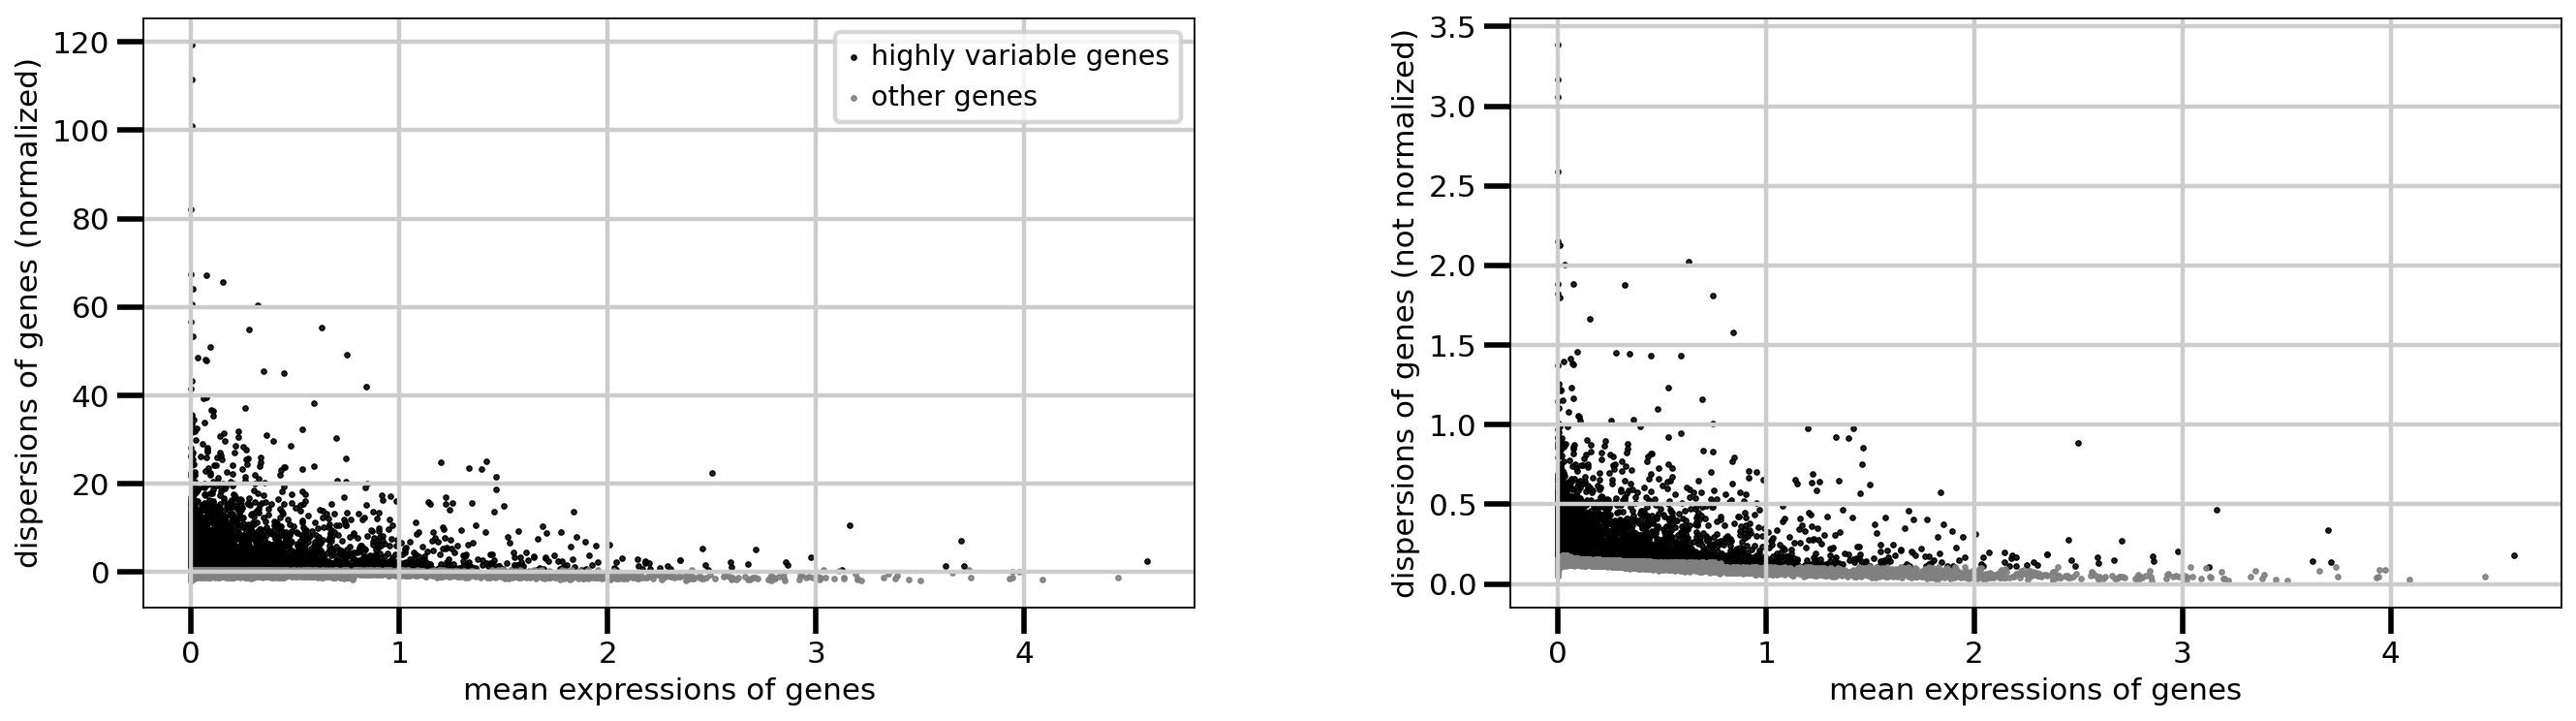

(4034, 29046)


In [19]:
from matplotlib import rcParams

rcParams['figure.figsize']=(10,5)
sc.pl.highly_variable_genes(adata)

print(adata.shape)

(4034, 10000)


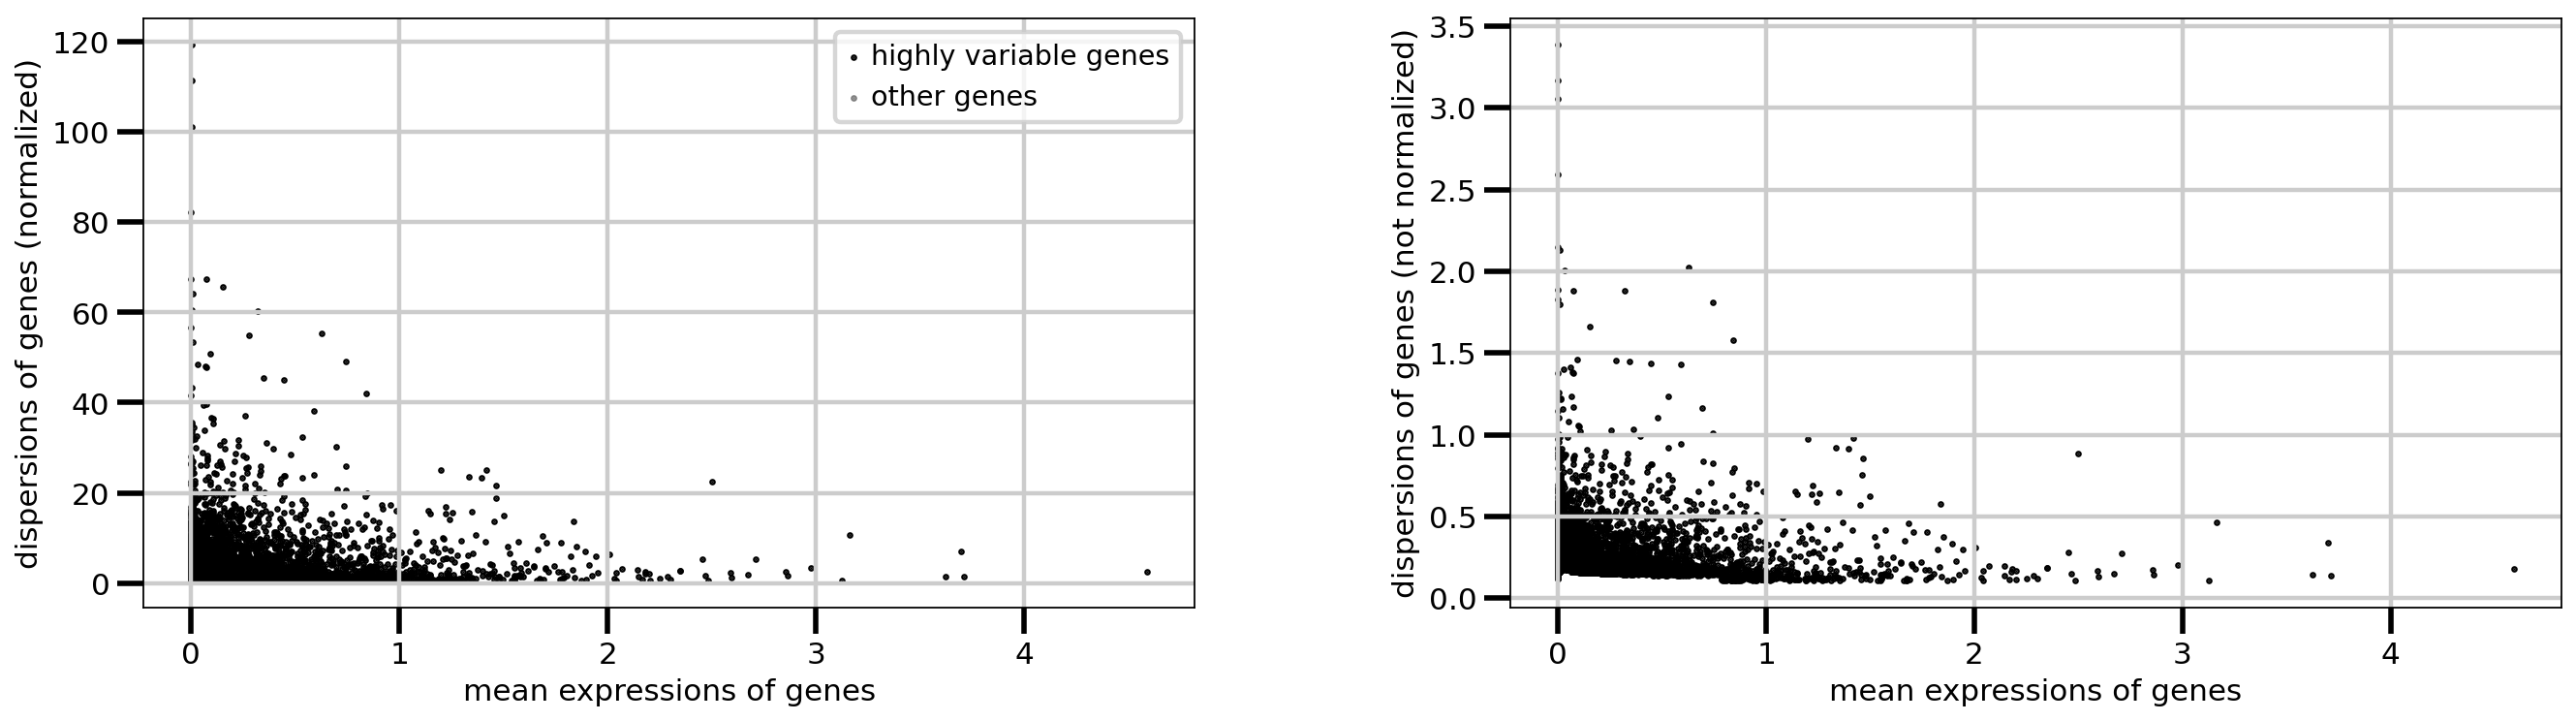

In [20]:
# keep only highly varialble genes
adata = adata[:, adata.var.highly_variable] 
print(adata.shape)
sc.pl.highly_variable_genes(adata)

Regress out mitochondrial and Scale

In [21]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) 
sc.pp.scale(adata, max_value=10) # have the numbers around zero

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:53)


## Export Filtered, Normalized, Scaled and Highly Variable Genes only

In [22]:
adata.write_h5ad(
    os.path.join(path_config.output_path,campari_file)
)

In [23]:
adata.shape

(4034, 10000)